In [1]:
import numpy as np
import pandas as pd
import helper_functions as hf
import keras_tuner as kt
from tensorflow.keras import callbacks
from tensorflow.keras import utils

import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)

In [2]:
nickel_data = pd.read_csv("dataWithHeat.csv", index_col=0)
# nickel_data = nickel_data.drop(columns="Name")
nickel_data.head()

,Name,"Tensile Strength, Yield",Heat treatment 1 Temperature,Heat treatment 1 Time,Heat treatment 2 Temperature,Heat treatment 2 Time,Heat treatment 3 Temperature,Heat treatment 3 Time,Heat treatment 4 Temperature,Heat treatment 4 Time,...,Ta,Ti,V,W,Y,Th,O,Zr,"Tensile Strength, Ultimate",Elongation at Break
0,Allvac718PLUS,989.0,954.0,1.0,788.0,8.0,704.0,8,760.0,500,...,0.0,0.7,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN
1,HastelloyS,NaN,1121.0,0.0,0.0,0.0,0.0,0,0.0,0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,845.0,NaN
2,Haynes230,NaN,1232.0,0.0,0.0,0.0,0.0,0,0.0,0,...,0.0,0,0.0,14.0,0.0,0.0,0.0,0.0,NaN,NaN
3,Waspaloy,NaN,1010.0,4.0,843.0,4.0,760.0,16,0.0,0,...,0.0,3,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,Unnamedalloy10,NaN,0.0,0.0,0.0,0.0,0.0,0,0.0,0,...,0.0,4.1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


## Train a neural network for UTS

In [3]:
# uts_data = nickel_data.dropna(subset="Tensile Strength, Ultimate")
# uts_data = uts_data.drop(
#     columns=['Tensile Strength, Yield', 'Elongation at Break'])
# uts_data = uts_data.fillna(0)
# uts_data = uts_data.astype("float32")

uts_data = hf.clean_dataframe(nickel_data, "Tensile Strength, Ultimate")
uts_data.head()

,Heat treatment 1 Time,Heat treatment 2 Time,Heat treatment 3 Time,Heat treatment 4 Time,Al,B,C,Co,Cr,Cu,...,stage_2_Hot,stage_2_No_HT,stage_2_Warm,stage_3_Anneal,stage_3_Hot,stage_3_No_HT,stage_3_Warm,stage_4_Hot,stage_4_No_HT,stage_4_Warm
1,0.0,0.0,0.0,0.0,0.30,0.000,0.000,0.0,15.5,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6,0.0,0.0,0.0,0.0,0.46,0.003,0.031,0.0,18.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
9,0.0,0.0,0.0,0.0,6.10,0.012,0.120,0.0,12.5,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
11,4.0,4.0,24.0,16.0,3.87,0.020,0.015,16.9,14.8,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
13,1.0,4.0,8.0,8.0,5.40,0.000,0.008,35.0,3.3,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [4]:
uts_data = uts_data.drop(columns=["Heat treatment 1 Time", "Heat treatment 2 Time", "Heat treatment 3 Time", "Heat treatment 4 Time"])

In [5]:

uts_train_data = uts_data.sample(frac=0.8, random_state=2212)
uts_test_data = uts_data.drop(uts_train_data.index)

uts_data.head()

,Al,B,C,Co,Cr,Cu,Fe,Hf,La,Mg,...,stage_2_Hot,stage_2_No_HT,stage_2_Warm,stage_3_Anneal,stage_3_Hot,stage_3_No_HT,stage_3_Warm,stage_4_Hot,stage_4_No_HT,stage_4_Warm
1,0.30,0.000,0.000,0.0,15.5,0.0,1.00,0.0,0.0,0.000,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6,0.46,0.003,0.031,0.0,18.0,0.0,18.25,0.0,0.0,0.001,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
9,6.10,0.012,0.120,0.0,12.5,0.0,0.00,0.0,0.0,0.000,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
11,3.87,0.020,0.015,16.9,14.8,0.0,0.40,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
13,5.40,0.000,0.008,35.0,3.3,0.0,25.00,0.0,0.0,0.000,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [6]:
uts_train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Al,718.0,2.466309,1.938354,0.0,0.5750,2.400000,4.0000,6.300000
B,718.0,0.011534,0.014826,0.0,0.0020,0.009950,0.0150,0.160000
C,718.0,0.062382,0.045515,0.0,0.0300,0.050000,0.0875,0.180000
Co,718.0,8.614276,7.768275,0.0,0.0000,10.000000,14.7500,35.000000
Cr,718.0,15.435473,4.835070,0.0,13.2000,16.000000,18.5450,29.500000
Cu,718.0,0.000508,0.001691,0.0,0.0000,0.000000,0.0000,0.014000
Fe,718.0,7.093789,11.766287,0.0,0.0000,0.000000,17.4100,45.220001
Hf,718.0,0.002786,0.074639,0.0,0.0000,0.000000,0.0000,2.000000
La,718.0,0.000000,0.000000,0.0,0.0000,0.000000,0.0000,0.000000
Mg,718.0,0.000100,0.000950,0.0,0.0000,0.000000,0.0000,0.019000


In [7]:
uts_train_features = uts_train_data.copy()
uts_test_features = uts_test_data.copy()

uts_train_labels = uts_train_features.pop("Tensile Strength, Ultimate")
uts_test_labels = uts_test_features.pop("Tensile Strength, Ultimate")

In [8]:
uts_normalizer = hf.normalize(uts_train_features)

First example: [[ 1.22  0.    0.06  0.36 17.78  0.   18.87  0.    0.    0.    0.11  2.93
   0.    3.94 53.28  0.    0.    0.    0.88  0.    0.56  0.    0.    0.
   0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    1.    0.
   0.    0.    1.    0.    0.    1.  ]]

Normalized: [[-0.64 -0.45 -0.1  -1.06  0.49  1.47  1.   -0.04  0.   -0.11  0.16 -0.16
  -0.13  1.23 -0.34 -0.32  0.    0.    4.07 -0.44 -1.04 -0.19 -0.51  0.
   0.    0.   -0.57 -1.31  1.74 -0.34 -0.12 -0.45 -0.77 -0.58  1.95 -0.17
  -0.56 -0.9   1.58 -0.29 -2.38  3.54]]


In [9]:
hf.model_builder(kt.HyperParameters(), uts_normalizer)

In [10]:
tuner = kt.Hyperband(lambda hp : hf.model_builder(hp, norm=uts_normalizer),
                     objective='val_loss',
                     max_epochs=5,
                     factor=3,
                     directory='model_search',
                     project_name='uts_model',
                     hyperband_iterations=2,
                     overwrite=True)

es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)

In [11]:
tuner.search_space_summary(extended=True)

Search space summary
Default search space size: 2
layer_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 200, 'max_value': 200, 'step': 1, 'sampling': None}
layer_2_units (Int)
{'default': None, 'conditions': [], 'min_value': 200, 'max_value': 200, 'step': 1, 'sampling': None}


In [12]:
tuner.search(uts_train_features, uts_train_labels, epochs=5, validation_split=0.2, callbacks=[es], verbose=2)


Trial 1 Complete [00h 00m 01s]
val_loss: 297.7991027832031

Best val_loss So Far: 297.7991027832031
Total elapsed time: 00h 00m 01s
INFO:tensorflow:Oracle triggered exit


In [13]:
tuner.results_summary()

Results summary
Results in model_search\uts_model
Showing 10 best trials
Trial summary
Hyperparameters:
layer_1_units: 200
layer_2_units: 200
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 297.7991027832031


In [14]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [15]:
best_hps.get_config()['values']

{'layer_1_units': 200,
 'layer_2_units': 200,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 1,
 'tuner/round': 0}

In [16]:
uts_model = tuner.hypermodel.build(best_hps)

uts_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 42)               85        
 n)                                                              
                                                                 
 dropout_3 (Dropout)         (None, 42)                0         
                                                                 
 dense_3 (Dense)             (None, 200)               8600      
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                                 
 dense_4 (Dense)             (None, 200)               40200     
                                                                 
 dropout_5 (Dropout)         (None, 200)               0         
                                                      

In [22]:
history = uts_model.fit(uts_train_features, uts_train_labels, epochs=10000, callbacks=[es], validation_split=0.2, verbose=2)

Epoch 1/10000
18/18 - 0s - loss: 222.2081 - val_loss: 211.0215 - 72ms/epoch - 4ms/step
Epoch 2/10000
18/18 - 0s - loss: 211.4366 - val_loss: 220.7997 - 44ms/epoch - 2ms/step
Epoch 3/10000
18/18 - 0s - loss: 218.6368 - val_loss: 210.5788 - 46ms/epoch - 3ms/step
Epoch 4/10000
18/18 - 0s - loss: 211.2974 - val_loss: 219.8999 - 44ms/epoch - 2ms/step
Epoch 5/10000
18/18 - 0s - loss: 215.5067 - val_loss: 209.9092 - 43ms/epoch - 2ms/step
Epoch 6/10000
18/18 - 0s - loss: 216.3115 - val_loss: 215.9872 - 45ms/epoch - 3ms/step
Epoch 7/10000
18/18 - 0s - loss: 205.5327 - val_loss: 222.9497 - 50ms/epoch - 3ms/step
Epoch 8/10000
18/18 - 0s - loss: 200.9219 - val_loss: 217.3304 - 45ms/epoch - 3ms/step
Epoch 9/10000
18/18 - 0s - loss: 210.6629 - val_loss: 218.9783 - 48ms/epoch - 3ms/step
Epoch 10/10000
18/18 - 0s - loss: 206.9394 - val_loss: 211.5317 - 45ms/epoch - 3ms/step
Epoch 11/10000
18/18 - 0s - loss: 218.9599 - val_loss: 216.2271 - 42ms/epoch - 2ms/step
Epoch 12/10000
18/18 - 0s - loss: 207.406

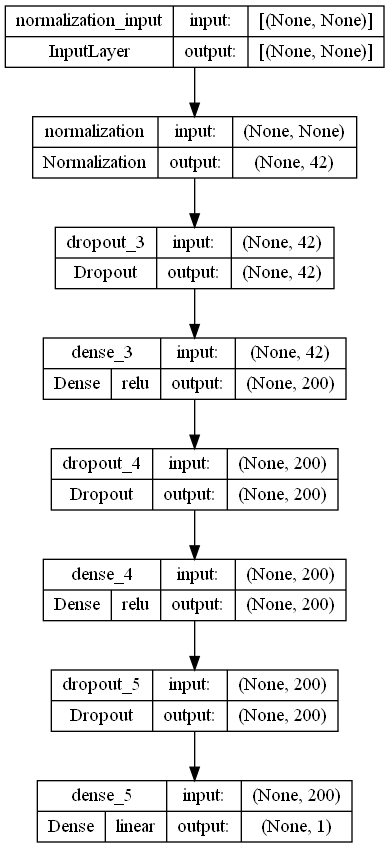

In [23]:
utils.plot_model(uts_model, show_layer_activations=True, show_shapes=True)

In [24]:
uts_model.evaluate(uts_test_features, uts_test_labels, verbose=0)

165.57574462890625

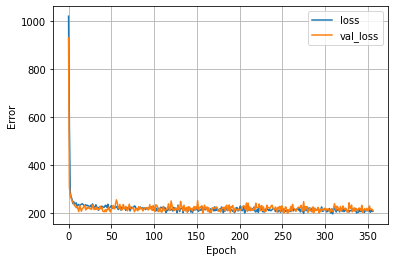

In [20]:
hf.plot_loss(history)

6/6 [==============================] - 0s 1ms/step


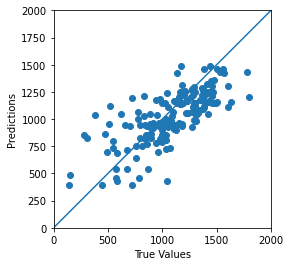

In [21]:
test_predictions = uts_model.predict(uts_test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(uts_test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 2000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)